In [ ]:
import networkx as nx
import numpy as np

# Visualizing the Graph

In [ ]:
G= nx.karate_club_graph()
type(G)

networkx.classes.graph.Graph

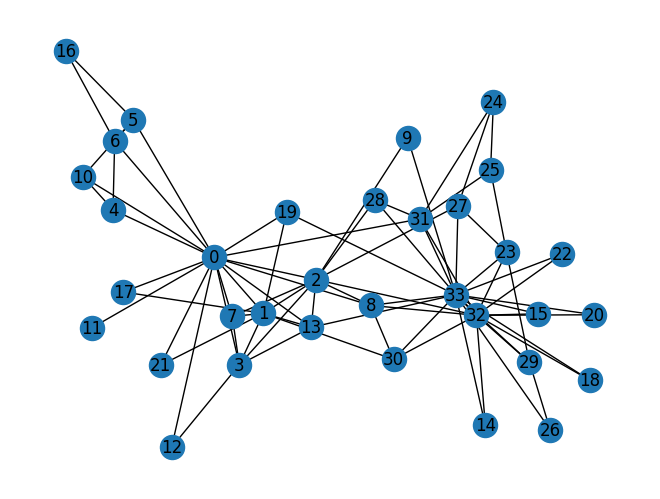

In [ ]:
nx.draw(G, with_labels= True)

# Degree

In [ ]:
# Average degree

def average_degree(num_edges, num_nodes):
  return round(2* num_edges / num_nodes)

num_edges= G.number_of_edges()
num_nodes= G.number_of_nodes()

print("average deg is:", average_degree(num_edges, num_nodes))

average deg is: 5


# Custering Coefficient

In [ ]:
# Clustering Coefficient

def clustering_coefficient(graph,node):
  
  N= [i for i in graph.neighbors(node)]
  if len(N)==0:
    return 0
  else:
   d= {}
   for neighbor in N:
     d[neighbor]= [i for i in graph.neighbors(neighbor)]
  
   e= 0
   for node in d:
     for i in d[node]:
       if i in N:
         e+=1
   return (e)/(max(1,len(N)*(len(N)-1)))

print(clustering_coefficient(G,0))

0.15


In [ ]:
# Average Clustering Coefficient

def average_clustering_coefficient(graph):

  s = 0
  for node in graph:
    s+= clustering_coefficient(graph,node)
  return s/len(graph)

print(round(average_clustering_coefficient(G),2))

# OR
'''
def average_clustering_coefficient(graph):
    avg = nx.average_clustering(G)
    avg = round(avg_cluster_coef, 2)
    return avg
'''

0.57


'\ndef average_clustering_coefficient(graph):\n    avg = nx.average_clustering(G)\n    avg = round(avg_cluster_coef, 2)\n    return avg\n'

# Page Rank(matrix version)

In [ ]:
# Page Rank

#beta
def pagerank(graph, num_iters, beta):

  d = {}
  i = 0
  for node in graph:
    N= [i for i in graph.neighbors(node)]
    d[i] = N
    i+= 1

  N= len(graph)
  r= np.zeros((1,N))
  r= r+1

  G= np.zeros((N,N))
  A= np.zeros((N,N))
  A= (A+1) * 1/N

  for i in d:
    for j in d[i]:
      G[i,j] = 1/(len(d[i]))
  
  G= beta*G + (1-beta)*A
  G= np.linalg.matrix_power(G, num_iters)
  return np.matmul(r, G)

P= pagerank(G, 12, 0.9)
print(P)

[[3.37166653 1.84372401 2.01086022 1.24459788 0.72639821 0.96821451
  0.96821451 0.84382877 1.03545228 0.46818007 0.72639821 0.29059461
  0.47737731 1.03087497 0.47480073 0.47480073 0.53569108 0.4759122
  0.47480073 0.6629584  0.47480073 0.4759122  0.47480073 1.07674119
  0.69417859 0.69244348 0.48551357 0.86991804 0.65888558 0.88542784
  0.84550523 1.27985103 2.48014765 3.50052818]]


# DeepWalk(& obtaiting embeddings with it)

In [ ]:
import networkx as nx
import random
import numpy as np
from typing import List
from tqdm import tqdm
from gensim.models.word2vec import Word2Vec


class DeepWalk:
    def __init__(self, window_size: int, embedding_size: int, walk_length: int, walks_per_node: int):
        """
        :param window_size: window size for the Word2Vec model
        :param embedding_size: size of the final embedding
        :param walk_length: length of the walk
        :param walks_per_node: number of walks per node
        """
        self.window_size = window_size
        self.embedding_size = embedding_size
        self.walk_length = walk_length
        self.walk_per_node = walks_per_node

    def random_walk(self, g: nx.Graph, start: str, use_probabilities: bool = False) -> List[str]:
        """
        Generate a random walk starting on start
        :param g: Graph
        :param start: starting node for the random walk
        :param use_probabilities: if True take into account the weights assigned to each edge to select the next candidate
        :return:
        """
        walk = [start]
        for i in range(self.walk_length):
            neighbours = g.neighbors(walk[i])
            neighs = list(neighbours)
            if use_probabilities:
                probabilities = [g.get_edge_data(walk[i], neig)["weight"] for neig in neighs]
                sum_probabilities = sum(probabilities)
                probabilities = list(map(lambda t: t / sum_probabilities, probabilities))
                p = np.random.choice(neighs, p=probabilities)
            else:
                p = random.choice(neighs)
            walk.append(p)
        return walk

    def get_walks(self, g: nx.Graph, use_probabilities: bool = False) -> List[List[str]]:
        """
        Generate all the random walks
        :param g: Graph
        :param use_probabilities:
        :return:
        """
        random_walks = []
        for _ in range(self.walk_per_node):
            random_nodes = list(g.nodes)
            random.shuffle(random_nodes)
            for node in tqdm(random_nodes):
                random_walks.append(self.random_walk(g=g, start=node, use_probabilities=use_probabilities))
        return random_walks

    def compute_embeddings(self, walks: List[List[str]]):
        """
        Compute the node embeddings for the generated walks
        :param walks: List of walks
        :return:
        """
        model = Word2Vec(sentences=walks, window=self.window_size, vector_size=self.embedding_size)
        return model.wv

In [ ]:
model= DeepWalk(window_size=4, embedding_size=8, walk_length=6, walks_per_node=12)

In [ ]:
walks= model.get_walks(G, use_probabilities= False)

100%|██████████| 34/34 [00:00<00:00, 56770.04it/s]


In [ ]:
embeddings= model.compute_embeddings(walks)
i= 0
print(embeddings[0])
print(embeddings[1])

[-0.09186341  0.00973619  0.16705118  0.12719959 -0.03996212  0.11209659
  0.06575625 -0.14424133]
[ 0.0951217  -0.04349703  0.02903167  0.08951046  0.1169974  -0.0465656
  0.09719871 -0.151665  ]


In [ ]:
import torch
%matplotlib inline 
import matplotlib.pyplot as plt

# Graph & Embedding Visualization Functions

In [ ]:
#Helper functions for visualization

def visualize_graph(G, color):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                     node_color=color, cmap="Set2")
    plt.show()


def visualize_embedding(h, color, epoch=None, loss=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    h = h.detach().cpu().numpy()
    plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
    if epoch is not None and loss is not None:
      plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    plt.show()


# Installing torch_geometric

In [ ]:
# Installing torch geometric

!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
!pip install -q torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.6/107.6 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.2/209.2 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 10.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


# GCN Model

In [ ]:
from torch_geometric.datasets import KarateClub
dataset= KarateClub()

import torch
from torch.nn import Linear
from torch_geometric.nn import GCNConv


class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(1234)
        self.conv1 = GCNConv(dataset.num_features, 4)
        self.conv2 = GCNConv(4, 4)
        self.conv3 = GCNConv(4, 2)
        self.classifier = Linear(2, dataset.num_classes)

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = h.tanh()
        h = self.conv2(h, edge_index)
        h = h.tanh()
        h = self.conv3(h, edge_index)
        h = h.tanh()  # Final GNN embedding space.
        
        # Apply a final (linear) classifier.
        out = self.classifier(h)

        return out, h

model = GCN()
print(model)

GCN(
  (conv1): GCNConv(34, 4)
  (conv2): GCNConv(4, 4)
  (conv3): GCNConv(4, 2)
  (classifier): Linear(in_features=2, out_features=4, bias=True)
)


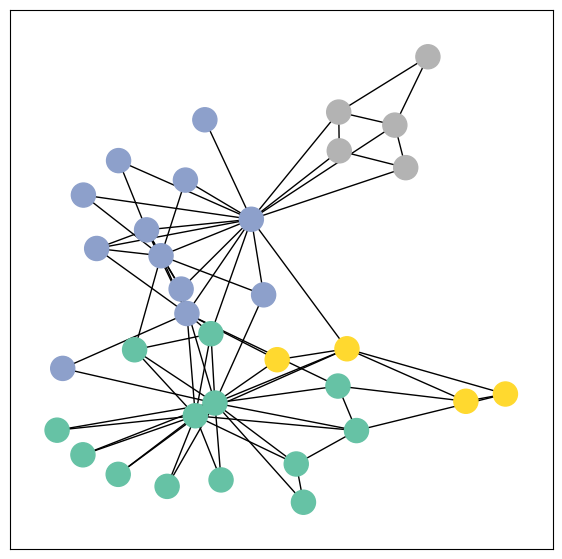

In [ ]:
from torch_geometric.utils import to_networkx

G = to_networkx(data, to_undirected=True)
visualize_graph(G, color=data.y)

# Training and Visualizing obtained Embeddings

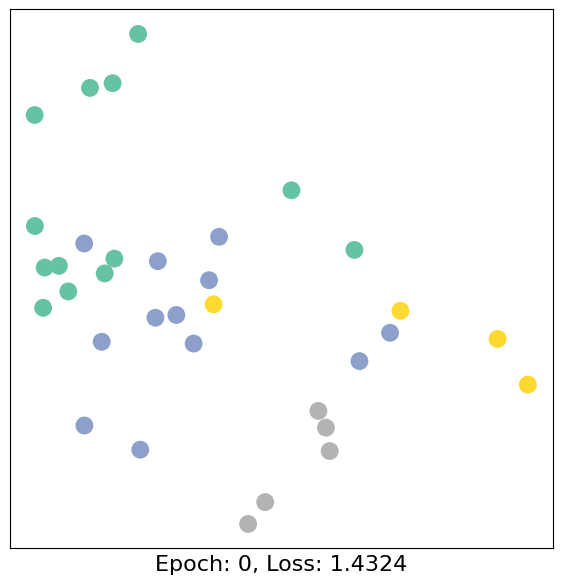

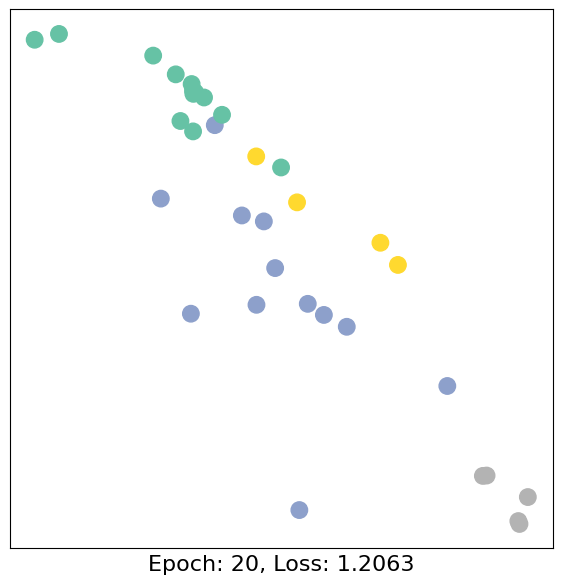

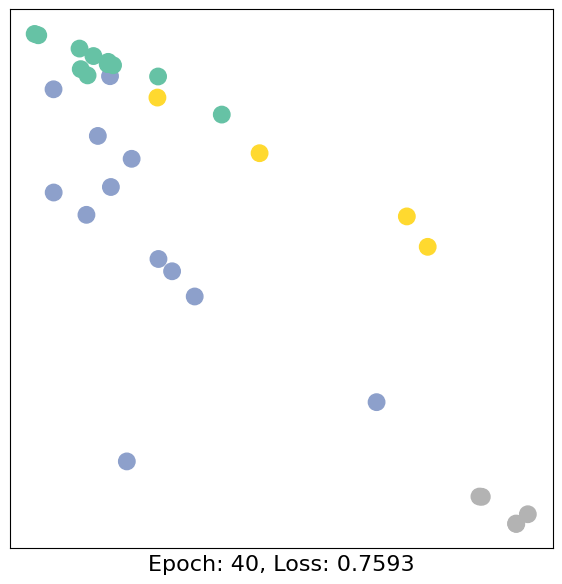

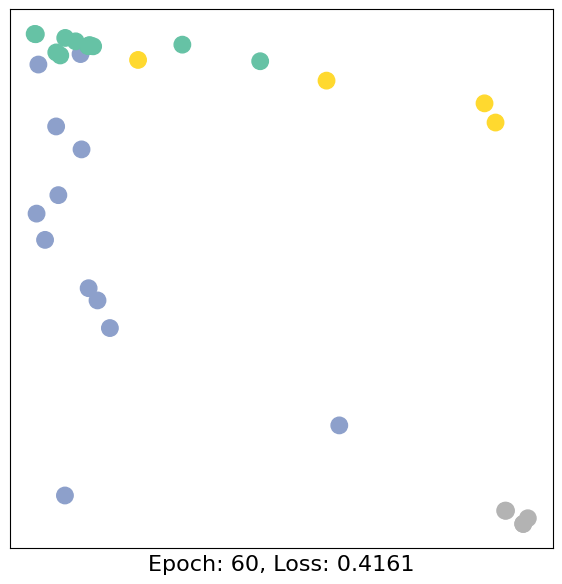

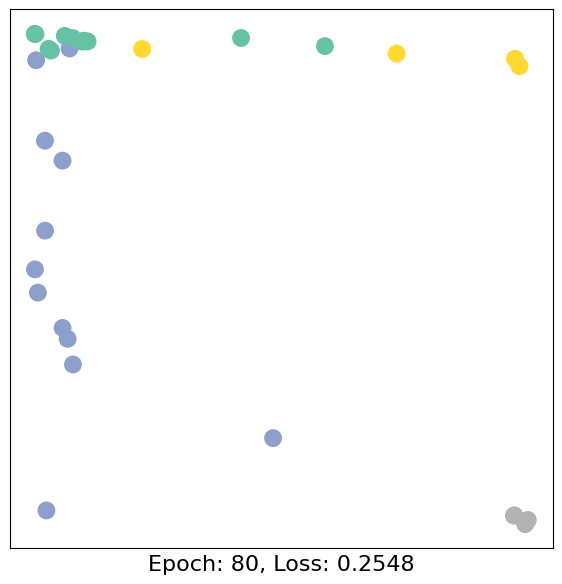

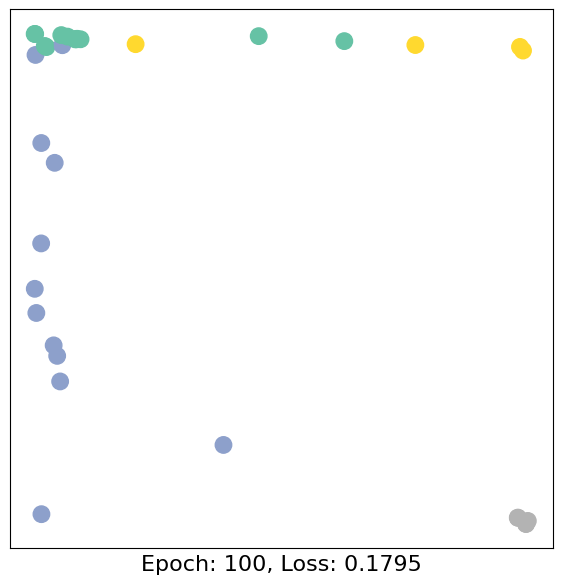

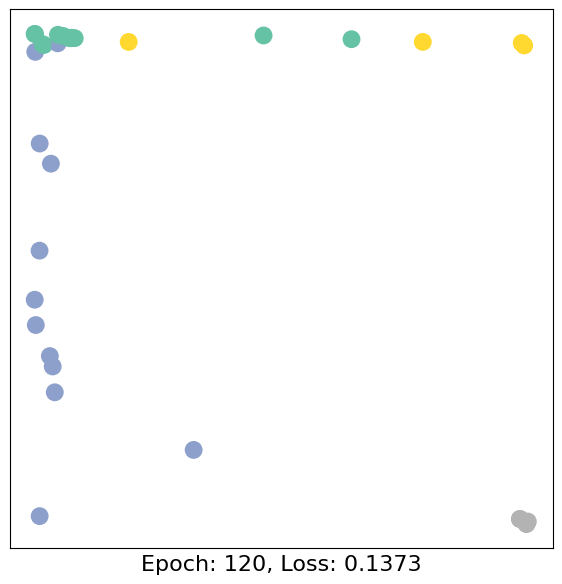

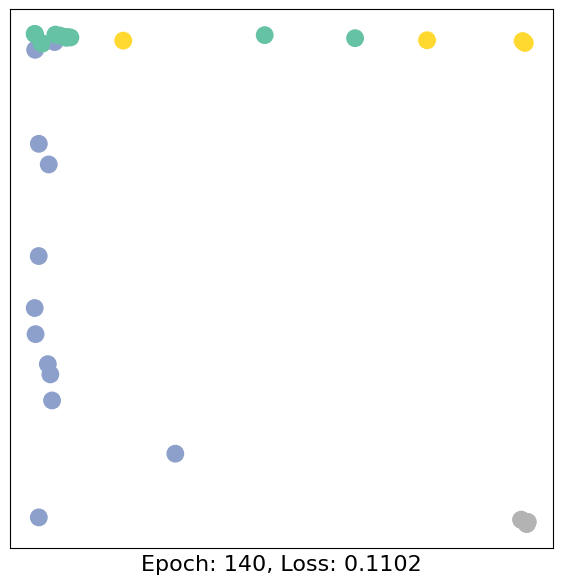

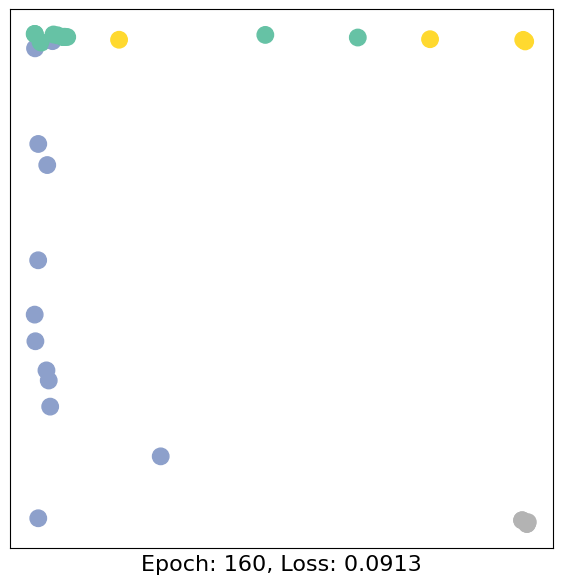

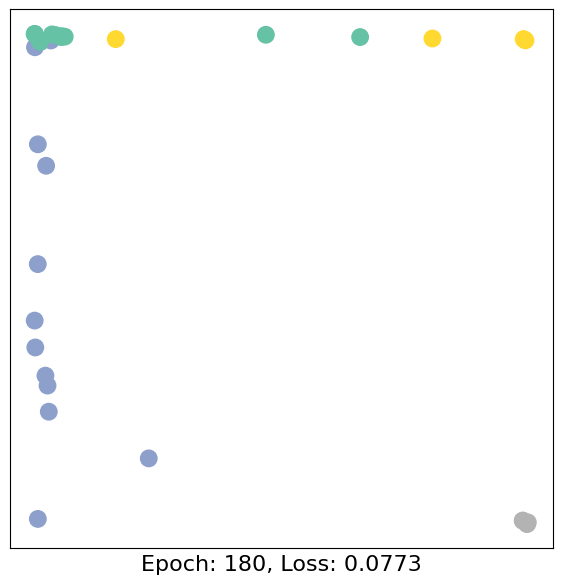

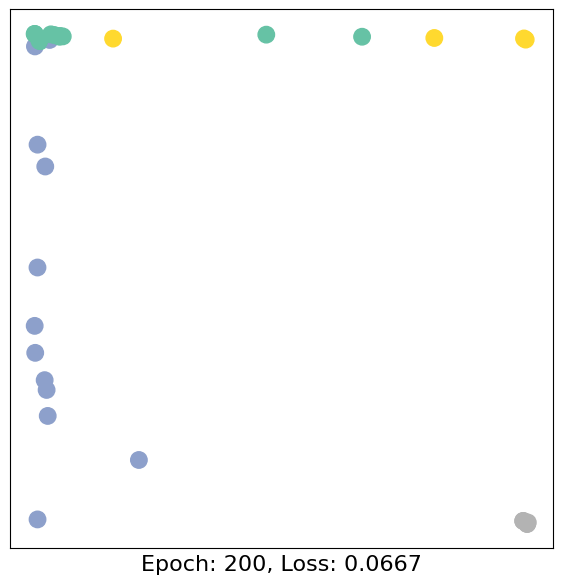

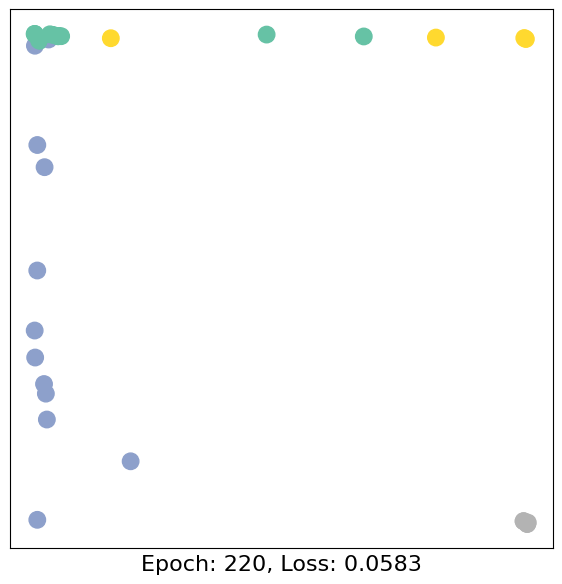

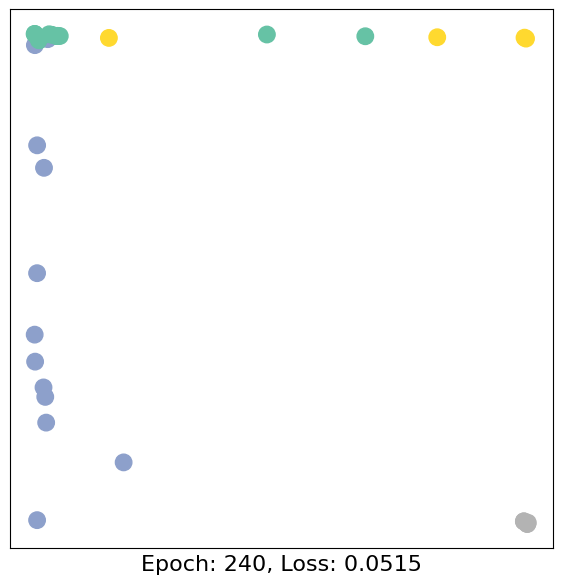

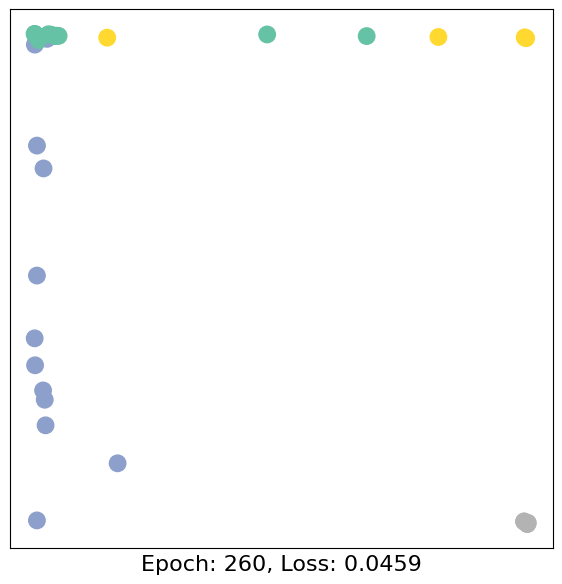

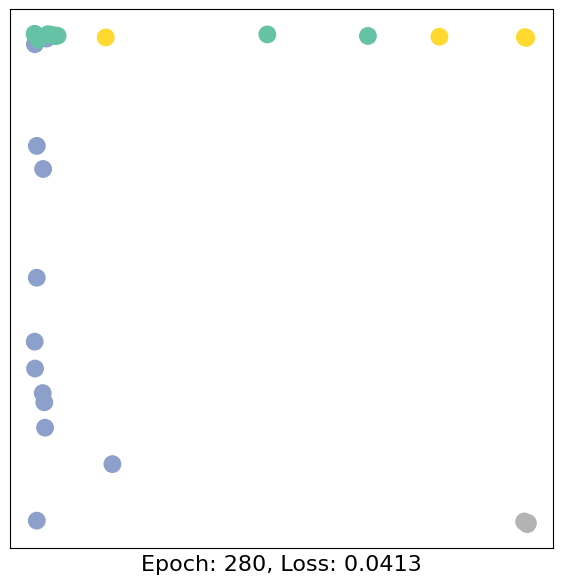

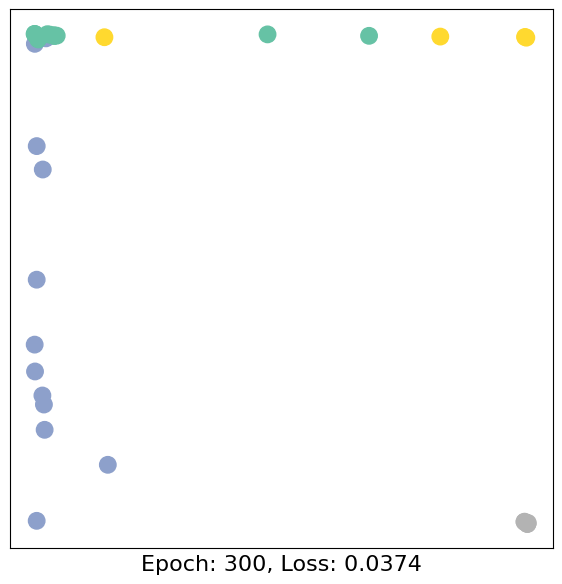

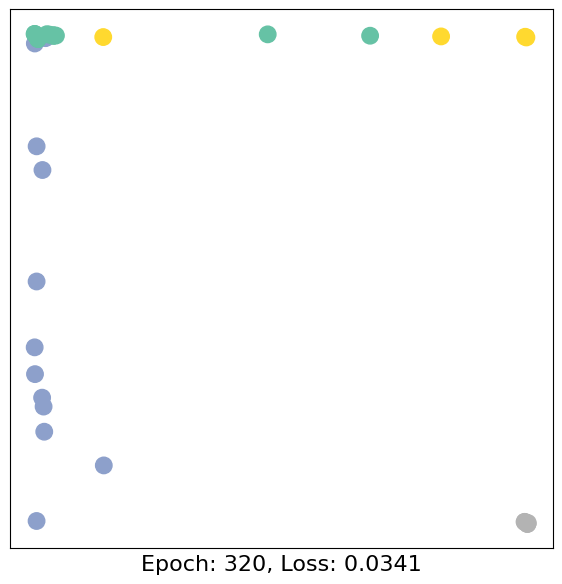

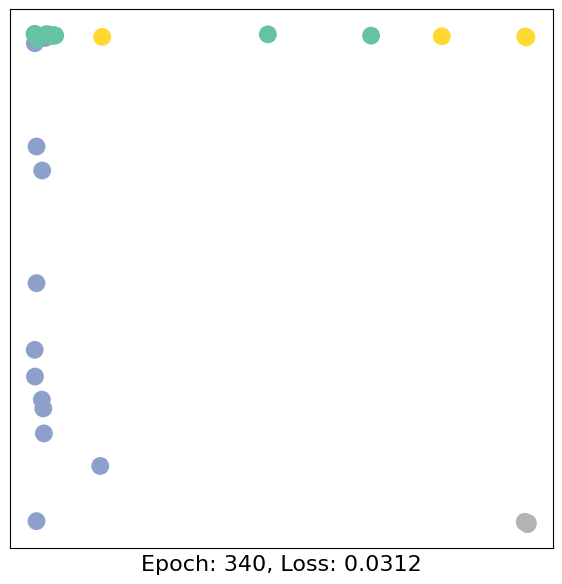

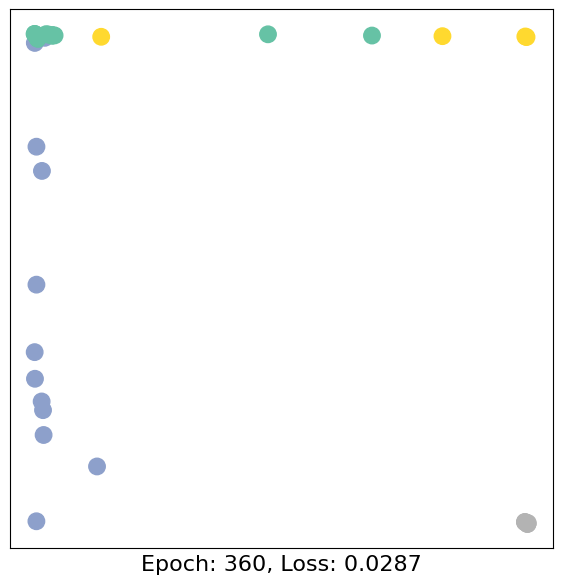

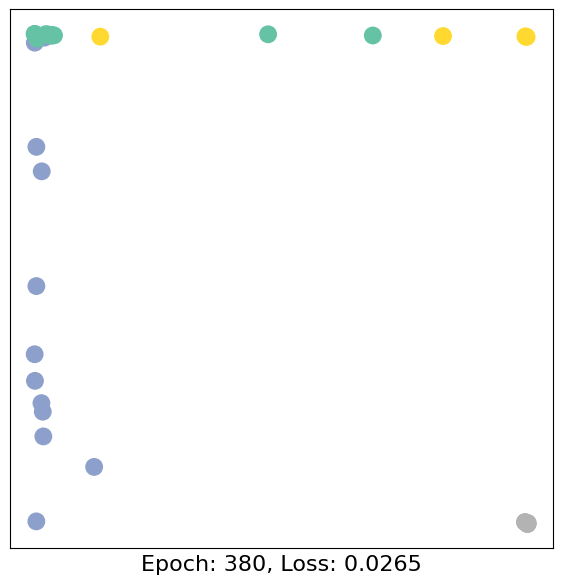

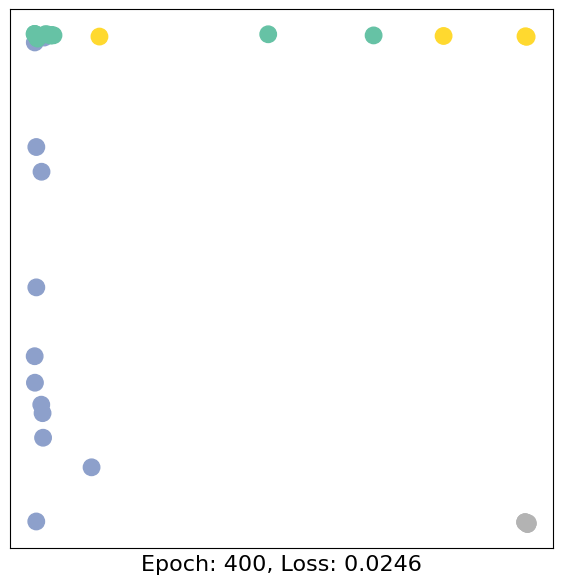

In [ ]:
#Embedding
import time
data = dataset[0]

model= GCN()
criterion= torch.nn.CrossEntropyLoss()
optimizer= torch.optim.Adam(model.parameters(), lr= 0.01)

def train(data):
  optimizer.zero_grad()
  out, h= model(data.x, data.edge_index)
  loss= criterion(out[data.train_mask], data.y[data.train_mask])
  loss.backward()
  optimizer.step()
  return loss, h

for epoch in range(401):
  loss, h= train(data)
  if epoch%20== 0:
    visualize_embedding(h, color=data.y, epoch=epoch, loss=loss)
    time.sleep(0.2)